In [4]:
from feature_engine.outliers import OutlierTrimmer


def trimmer_skewed_iqr(variables, x_train, x_test, y_train, y_test):
    """
    Apply a default OulierTrimmer for skewed distribution.
    """
    return _build_trimmer(variables, 'iqr', 1.5, x_train, x_test, y_train, y_test)


def trimmer_normal_gaussian(variables, x_train, x_test, y_train, y_test):
    """
    Apply a default OulierTrimmer for normal distribution.
    - Gaussian method based.
    """
    return _build_trimmer(variables, 'gaussian', 3, x_train, x_test, y_train, y_test)


def trimmer_normal_quantile(variables, x_train, x_test, y_train, y_test):
    """
    Apply a default OulierTrimmer for normal distribution.
    - Quantile range based;
    - Its more agressive than Gaussian.
    """
    return _build_trimmer(variables, 'quantiles', 0.01, x_train, x_test, y_train, y_test)


def _build_trimmer(variables, capping_method, fold, x_train, x_test, y_train, y_test):
    trimmer = OutlierTrimmer(
        variables=variables,
        capping_method=capping_method,
        tail='both',
        fold=fold
    )
    trimmer.fit(x_train)
    # print(trimmer.left_tail_caps_)
    # print(trimmer.right_tail_caps_)
    x_train_trimmed = trimmer.transform(x_train)
    y_train_trimmed = y_train[x_train_trimmed.index]
    x_test_trimmed = trimmer.transform(x_test)
    y_test_trimmed = y_test[x_test_trimmed.index]
    return x_train_trimmed, x_test_trimmed, y_train_trimmed, y_test_trimmed


def trimmer_skewed_iqr(variables, data_frame):
    return _build_trimmer(variables, 'iqr', 1.5, data_frame)


def trimmer_normal_gaussian(variables, data_frame):
    return _build_trimmer(variables, 'gaussian', 3, data_frame)


def trimmer_normal_quantile(variables, data_frame):
    return _build_trimmer(variables, 'quantiles', 0.01, data_frame)


def _build_trimmer(variables, capping_method, fold, data_frame):
    return OutlierTrimmer(
        variables=variables,
        capping_method=capping_method,
        tail='both',
        fold=fold
    ).fit_transform(data_frame)


In [7]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

data = pd.read_csv("datasets/houses_to_rent_v2.csv")
data.rename({"parking spaces": "parking_spaces",
             "hoa (R$)": "hoa",
             "rent amount (R$)": "rent",
             "property tax (R$)": "property_tax",
             "fire insurance (R$)": "fire_insurance",
             "total (R$)": "total"}, axis="columns", inplace=True)
data.describe()

 

,area,rooms,bathroom,parking_spaces,hoa,rent,property_tax,fire_insurance,total
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


In [10]:

# pré-processamento
df = data.drop(["total", "floor"], axis=1)
df.drop_duplicates(inplace=True)
# remoção de outliers
df = trimmer_skewed_iqr(
    variables=['area', 'hoa', 'property_tax', 'fire_insurance'],
    data_frame=df,
)
df = trimmer_normal_quantile(
    variables=['rooms', 'bathroom', 'parking_spaces'],
    data_frame=df,
)

df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8464 entries, 0 to 10691
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   city            8464 non-null   object
 1   area            8464 non-null   int64 
 2   rooms           8464 non-null   int64 
 3   bathroom        8464 non-null   int64 
 4   parking_spaces  8464 non-null   int64 
 5   animal          8464 non-null   object
 6   furniture       8464 non-null   object
 7   hoa             8464 non-null   int64 
 8   rent            8464 non-null   int64 
 9   property_tax    8464 non-null   int64 
 10  fire_insurance  8464 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 793.5+ KB


In [ ]:
# separação dos dados de treino e teste
X = df.loc[:, df.columns != "rent"]
Y = df["rent"]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1)
# feature engineering
ct = make_column_transformer(
    (MinMaxScaler(),  # ou StandardScaler(), dependendo de qual performa melhor
     ['area', 'rooms', 'bathroom', 'parking_spaces', 'hoa', 'property_tax', 'fire_insurance']),
    (OneHotEncoder(categories="auto",
                   # to return k-1 (drop=false to return k dummies)
                   drop="first",
                   sparse_output=False,
                   handle_unknown="error"),
     ['city', 'animal', 'furniture']),
    remainder="passthrough"
)
ct.fit(X_train)
X_train = ct.transform(X_train)
X_test = ct.transform(X_test)

In [9]:
import pandas as pd

dados = {
    'parâmetro': ['camadas', 'neurônios por camada', 'taxa de aprendizagem (Adam)', 'tamanho dos lotes'],
    'mínimo': [1, 1, 0.00001, 4],
    'máximo': [10, 1000, 0.1, 4096],
    'carga de redução': ['vlr atual - 1', 'vlr atual + (-50 até 0)','vlr atual / 10', 'vlr atual / 2'],
    'carga de aumento': ['vlr atual + 1', 'vlr atual + (0 até 50)', 'vlr atual * 10', 'vlr atual * 2'],
}

df = pd.DataFrame(dados)

df.head()

,parâmetro,mínimo,máximo,carga de redução,carga de aumento
0,camadas,1.00000,10.0,vlr atual - 1,vlr atual + 1
1,neurônios por camada,1.00000,1000.0,vlr atual + (-50 até 0),vlr atual + (0 até 50)
2,taxa de aprendizagem (Adam),0.00001,0.1,vlr atual / 10,vlr atual * 10
3,tamanho dos lotes,4.00000,4096.0,vlr atual / 2,vlr atual * 2


In [5]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import joblib


data = pd.read_csv("datasets/houses_to_rent_v2.csv")
data.rename({"parking spaces": "parking_spaces",
             "hoa (R$)": "hoa",
             "rent amount (R$)": "rent",
             "property tax (R$)": "property_tax",
             "fire insurance (R$)": "fire_insurance",
             "total (R$)": "total"}, axis="columns", inplace=True)
# pré-processamento
df = data.drop(["total", "floor"], axis=1)
df.drop_duplicates(inplace=True)
# remoção de outliers
df = trimmer_skewed_iqr(
    variables=['area', 'hoa', 'property_tax', 'fire_insurance'],
    data_frame=df,
)
df = trimmer_normal_quantile(
    variables=['rooms', 'bathroom', 'parking_spaces'],
    data_frame=df,
)

df.describe()

,area,rooms,bathroom,parking_spaces,hoa,rent,property_tax,fire_insurance
count,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000,8464.000000
mean,102.201914,2.271739,1.861059,1.221763,709.233223,2888.544305,169.189627,39.014414
std,69.394277,0.974749,1.012541,1.111887,653.347263,2005.743921,192.724499,27.039667
min,11.000000,1.000000,1.000000,0.000000,0.000000,450.000000,0.000000,3.000000
25%,53.000000,1.000000,1.000000,0.000000,240.000000,1400.000000,30.000000,19.000000
50%,80.000000,2.000000,2.000000,1.000000,550.000000,2300.000000,100.000000,31.000000
75%,130.000000,3.000000,2.000000,2.000000,1015.000000,3700.000000,246.000000,51.000000
max,384.000000,5.000000,5.000000,6.000000,2970.000000,15000.000000,917.000000,143.000000


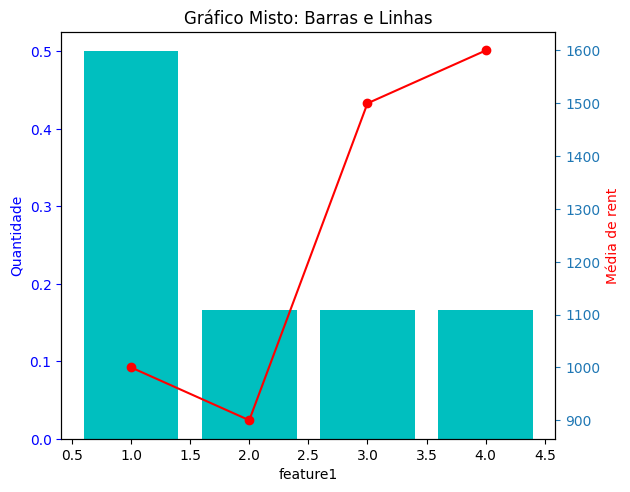

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Seu conjunto de dados
data = pd.DataFrame({'feature1': [1, 1, 1, 2, 3, 4],
                     'rent': [1000, 1200, 800, 900, 1500, 1600]})

# Calcular a média do valor de 'rent' para cada valor de 'feature1'
mean_rent = data.groupby('feature1')['rent'].mean().reset_index()

# Contar a quantidade de vezes que cada valor de 'feature1' aparece
count_feature = data['feature1'].value_counts(normalize=True).reset_index()

# Renomear as colunas
count_feature.columns = ['feature1', 'count']

# Criar o gráfico
fig, ax1 = plt.subplots()

# Gráfico de barras
ax1.bar(count_feature['feature1'], count_feature['count'], color='c', label='Quantidade')

# Eixo x e y para o gráfico de barras
ax1.set_xlabel('feature1')
ax1.set_ylabel('Quantidade', color='b')
ax1.tick_params('y', colors='b')

# Gráfico de linhas
ax2 = ax1.twinx()
ax2.plot(mean_rent['feature1'], mean_rent['rent'], color='r', label='Média de rent', marker='o')

# Eixo y para o gráfico de linhas
ax2.set_ylabel('Média de rent', color='r')
ax2.tick_params('y', colors='#1F77B4')

# Adicionar legenda
fig.tight_layout()
plt.title('Gráfico Misto: Barras e Linhas')
plt.show()
